In [12]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

pd.options.display.float_format = '{:,.2f}'.format
con = sqlite3.connect('../../datasets/checking-logs.sqlite')

## create a dataframe where each user of the `test` group has the `average difference`, number of `pageviews` and number of `commits`

In [13]:
num_commits = pd.read_sql_query(
    '''
        SELECT 
            c.uid, 
            COUNT(DISTINCT c.timestamp) AS num_commits,
            COUNT(DISTINCT p.datetime) AS pageviews
        FROM checker AS c
        INNER JOIN pageviews AS p ON c.uid = p.uid
        WHERE (
            c.uid LIKE 'user_%'
            AND c.labname <> 'project1'
        )        
        GROUP BY c.uid
    ''',
    con,
)
num_commits

,uid,num_commits,pageviews
0,user_1,62,28
1,user_10,20,89
2,user_14,61,143
3,user_17,51,47
4,user_18,5,3
5,user_19,118,16
6,user_21,65,10
7,user_25,79,179
8,user_28,60,149
9,user_3,18,317


In [14]:
avg_diff = pd.read_sql(
    '''
        SELECT uid, AVG(diff) AS avg_diff
        FROM (
            SELECT uid, labname,
                (
                    CAST(julianday(timestamp) - julianday(deadlines, 'unixepoch') AS INTEGER) * 24
                ) AS diff
            FROM checker AS c
            INNER JOIN deadlines AS d ON c.labname = d.labs
            WHERE (
                c.status = 'ready'
                AND c.numTrials = 1
                AND c.uid LIKE 'user_%'
                AND c.labname <> 'project1'
            )
            GROUP BY c.uid, c.labname
        )
        GROUP BY uid
    ''',
    con
)
avg_diff.head()

,uid,avg_diff
0,user_1,-57.60
1,user_10,-62.40
2,user_11,0.00
3,user_12,-78.00
4,user_13,-42.00


In [15]:
df = pd.merge(num_commits, avg_diff, how='inner', on='uid')
df

,uid,num_commits,pageviews,avg_diff
0,user_1,62,28,-57.60
1,user_10,20,89,-62.40
2,user_14,61,143,-152.00
3,user_17,51,47,-52.80
4,user_18,5,3,0.00
5,user_19,118,16,-90.00
6,user_21,65,10,-90.00
7,user_25,79,179,-86.40
8,user_28,60,149,-81.60
9,user_3,18,317,-96.00


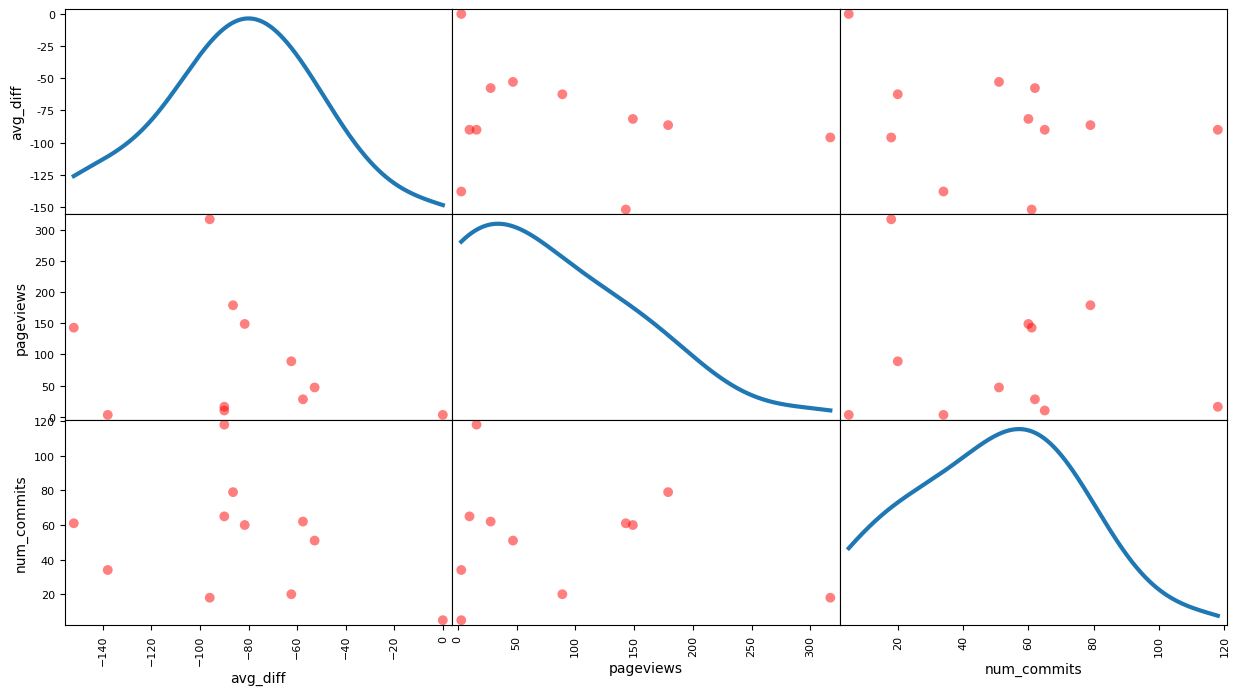

In [16]:
scatter_props = {
    'diagonal': 'kde',
    'figsize': (15, 8),
    'color': 'RED',
    's': 200,
    'density_kwds': {
      'linewidth': 3,
    }
}

matrix = scatter_matrix(
  df[['avg_diff', 'pageviews', 'num_commits']],
  **scatter_props
)

## Can we say that if a user has a `low` number of `pageviews` then they likely have a `low` number of `commits`?
* No

## Can we say that if a user has a `low` number of `pageviews` then they likely have a `small` `average` difference between the first commit and the lab deadline?
* No

## Can we say that there are `many users` with a `low` number of `commits` and a `few` with a `high` number of `commits`
* Yes

## Can we say that there are `many users` with a `small average` difference and a `few` with a `large average` difference
* No

In [17]:
con.close()